In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import matplotlib.animation as animation

In [28]:
class GeneExpressionSystem(torch.nn.Module):
    def __init__(self, hidden_size=1):
        super().__init__()
        # Neural network that takes y as input and outputs shape(y)
        self.shape_net = torch.nn.Sequential(
            torch.nn.Linear(1, hidden_size), torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 1), torch.nn.Sigmoid()  # Output in (0,1)
        )

    def forward(self, t, y):
        y = y.view(-1, 1)  # Ensure correct input shape

        # Compute shape as a function of y
        shape = self.shape_net(y)  # Output in (0,1)

        # ODE equation: dy/dt = shape(y) - y
        dydt = shape - y
        return dydt.view(-1)  # Ensure correct shape for odeint


In [35]:
# Initialize model
model = GeneExpressionSystem()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Target conditions
initial_y = torch.tensor([0.5])  # Start at y(0) = 0.5
target_y = torch.tensor([3.0])   # We want y(8) = 3

# Time points (simulate from t=0 to t=3)
t = torch.linspace(0, 3, 50)

# Training loop
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Solve ODE
    y_states = odeint(model, initial_y, t)
    
    # Extract y at t=2
    y_pred = y_states[(t - 2).abs().argmin()]  # Closest index to t=2
    
    # Compute loss (MSE)
    loss = (y_pred - target_y) ** 2
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print progress every 50 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 6.820160
Epoch 50: Loss = 4.408808


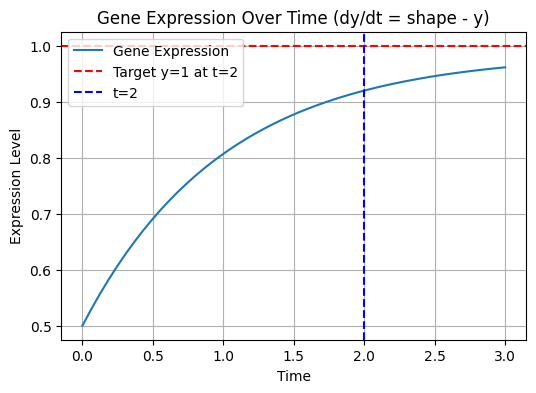

In [37]:
# Solve final ODE after training
with torch.no_grad():
    y_states = odeint(model, initial_y, t)

# Plot results
plt.figure(figsize=(6, 4))
plt.plot(t, y_states, label="Gene Expression")
plt.axhline(1, color="red", linestyle="--", label="Target y=1 at t=2")
plt.axvline(2, color="blue", linestyle="--", label="t=2")
plt.xlabel("Time")
plt.ylabel("Expression Level")
plt.title("Gene Expression Over Time (dy/dt = shape - y)")
plt.legend()
plt.grid(True)
plt.show()